In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
#%matplotlib inline

In [3]:
def calibrate_camera(images, grid_size=(9, 6)):
    """
    Calibrate camera parameters using images of 
    chesseboard

    :param images list : list of image path
    :param grid_size tuple: size of grid
    :param image_size tuple: size of image
    """
    if len(images) < 10:
        print('Not enough images for clibration!')
        return
    gw, gh = grid_size
    objp = np.zeros((gw*gh,3), np.float32)
    objp[:,:2] = np.mgrid[0:gw, 0:gh].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img_size = (0,0)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (gw,gh), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 1, img_size)
    return mtx, dist, newcameramtx, roi

def undistort_image(img, mtx, dist, newcameramtx=None, roi=None):
    """
    undistort image

    :param img image: image to be undistort
    :param mtx matrix: matrix for undisortion
    :param dist matrix : dist coeffients
    :param newcameramtx matrix: new camera matirx
    :param roi tuple: roi of valid pixels  
    """
    if (newcameramtx != None) and (roi != None):
        x,y,w,h = roi
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        dst = dst[y:y+h, x:x+w]
    else:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


In [4]:
def plot_imgs(im1, im2, titles=('IM1', 'IM2')):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(titles[0], fontsize=50)
    ax2.imshow(im2)
    ax2.set_title(titles[1], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        return img
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(255 * sobel / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel = np.uint8(255 * sobel / np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    sobel_x = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_angle = np.arctan2(sobel_y, sobel_x);
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_angle)
    binary_output[(grad_angle >= thresh[0]) & (grad_angle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
                   
                   
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(img_hls[:,:,-1])
    #binary_output = img_hls[:,:,-1]
    binary_output[(img_hls[:,:,-1] >= thresh[0]) & (img_hls[:,:,-1] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def combined_filter(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sx_idx = (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])
    sxbinary[sx_idx] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_idx = (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])
    s_binary[s_idx] = 1
    
    s_binary_new = np.zeros_like(s_channel)
    #s_binary_new[s_idx | sx_idx] = 255
    s_binary_new[s_idx | sx_idx ] = 255
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return s_binary_new, color_binary
    #return s_binary

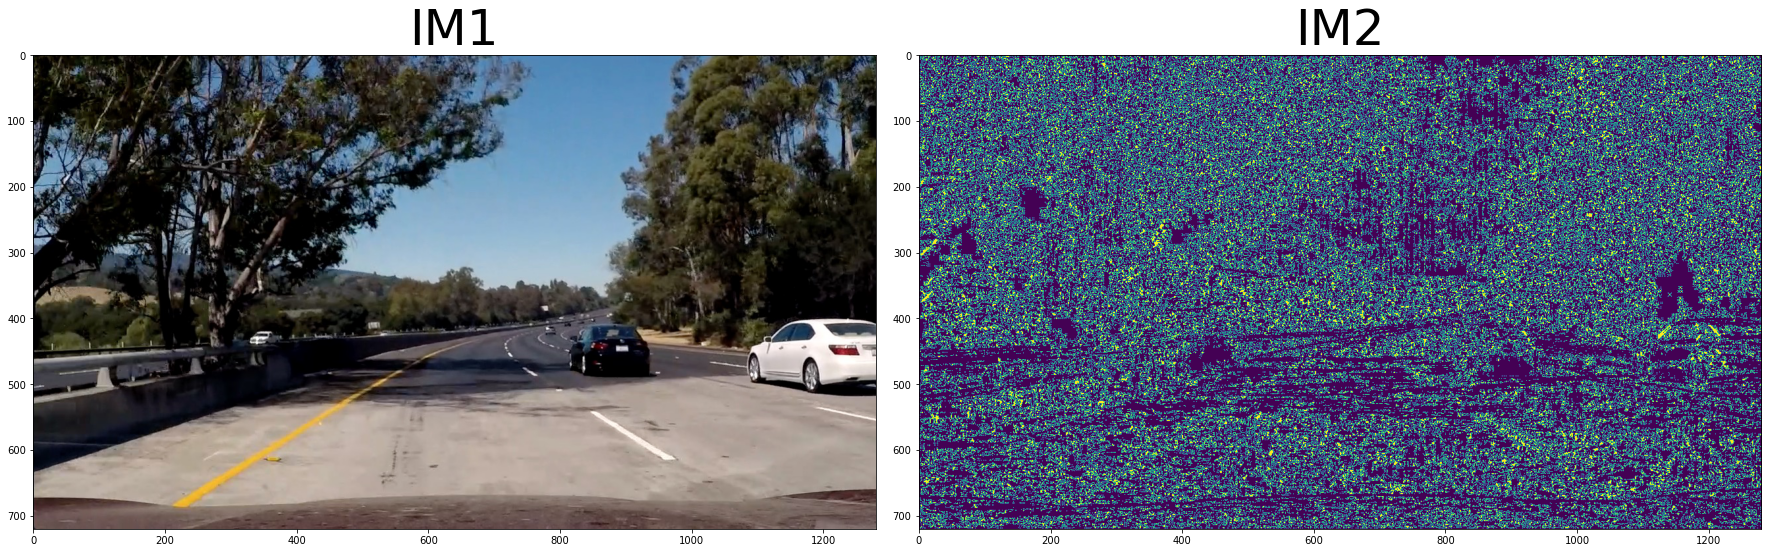

In [451]:
test_im = cv2.imread(test_ims[1])
dst = cv2.undistort(test_im, mtx, dist, None, mtx)
warped_im = cv2.warpPerspective(dst, perspective_matrix, (dst.shape[1], dst.shape[0]), cv2.INTER_LINEAR)
filtered_im, filtered_im_color = combined_filter(test_im)
filtered_im = dir_threshold(test_im, sobel_kernel=3, thresh=(np.pi/(2*3), np.pi/(2*3)*2))
plot_imgs(test_im[:,:,::-1], filtered_im)

In [15]:
def get_perspective_transform(size, src_vertices, offset=(300, 0)):
    offset_x, offset_y = offset
    w, h = size
    dst_vertices = np.array([[offset_x, h], [offset_x, offset_y], [w-offset_x, offset_y], [w-offset_x, h]], dtype=np.float32)
    m = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    return m

In [91]:
def find_lane_pixels(binary_warped, nwindows=9, xmargin=100, minpix=20):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - xmargin
        win_xleft_high = leftx_current + xmargin  # Update this
        win_xright_low = rightx_current - xmargin  # Update this
        win_xright_high = rightx_current + xmargin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        y_idx = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & y_idx).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & y_idx).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = nonzerox[good_left_inds].mean().astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = nonzerox[good_right_inds].mean().astype(int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [92]:
def fit_polynomial(left, right):
    leftx, lefty = left
    rightx, righty = right
    left_fit = np.polyfit(lefty, leftx,  2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    
def __fit_polynomial(left, right, binary_warped):
    leftx, lefty = left
    rightx, righty = right
    left_fit = np.polyfit(lefty, leftx,  2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

In [108]:
def search_around_poly(binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    nonzero_x_curve_left = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    nonzero_x_curve_right = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    left_lane_inds = (nonzerox >= nonzero_x_curve_left - margin) & (nonzerox < nonzero_x_curve_left + margin)
    right_lane_inds = (nonzerox >= nonzero_x_curve_right - margin) & (nonzerox < nonzero_x_curve_right + margin)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return (leftx, lefty), (rightx, righty)
    
def visualize_poly(binary_warped, left_pixs, right_pixs, left_fit, right_fit, margin=100):
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    leftx, lefty = left_pixs
    rightx, righty = right_pixs
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

In [36]:
def convert_coef_pix2m(coef, xm_per_pix, ym_per_pix):
    a = coef[0] * xm_per_pix / (ym_per_pix**2)
    b = coef[0] * xm_per_pix / ym_per_pix
    return np.array([a, b, coef[2]])

In [111]:
def measure_curvature(left_fit, right_fit, y_eval):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    left_curverad = ((1 + (2*left_fit[0] * y_eval + left_fit[1])**2)**(3/2))/abs(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0] * y_eval + right_fit[1])**2)**(3/2))/abs(2*right_fit[0])
    
    return left_curverad, right_curverad

### 1. Calibrate camera

In [7]:
cali_path = 'camera_cal/*.jpg'
mtx, dist, newcameramtx, roi = calibrate_camera(glob.glob(cali_path))

In [8]:
test_img = cv2.imread(glob.glob(cali_path)[1])
undis_img = undistort_image(test_img, mtx, dist)
plot_imgs(test_img, undis_img)

In [9]:
np.linalg.inv(mtx)

array([[ 8.63723306e-04,  0.00000000e+00, -5.76201786e-01],
       [ 0.00000000e+00,  8.67436472e-04, -3.34938546e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [197]:
dist

array([[-0.24688507, -0.02373154, -0.00109831,  0.00035107, -0.00259869]])

### 2. Filter image

In [284]:
test_ims = glob.glob('test_images/*.jpg')

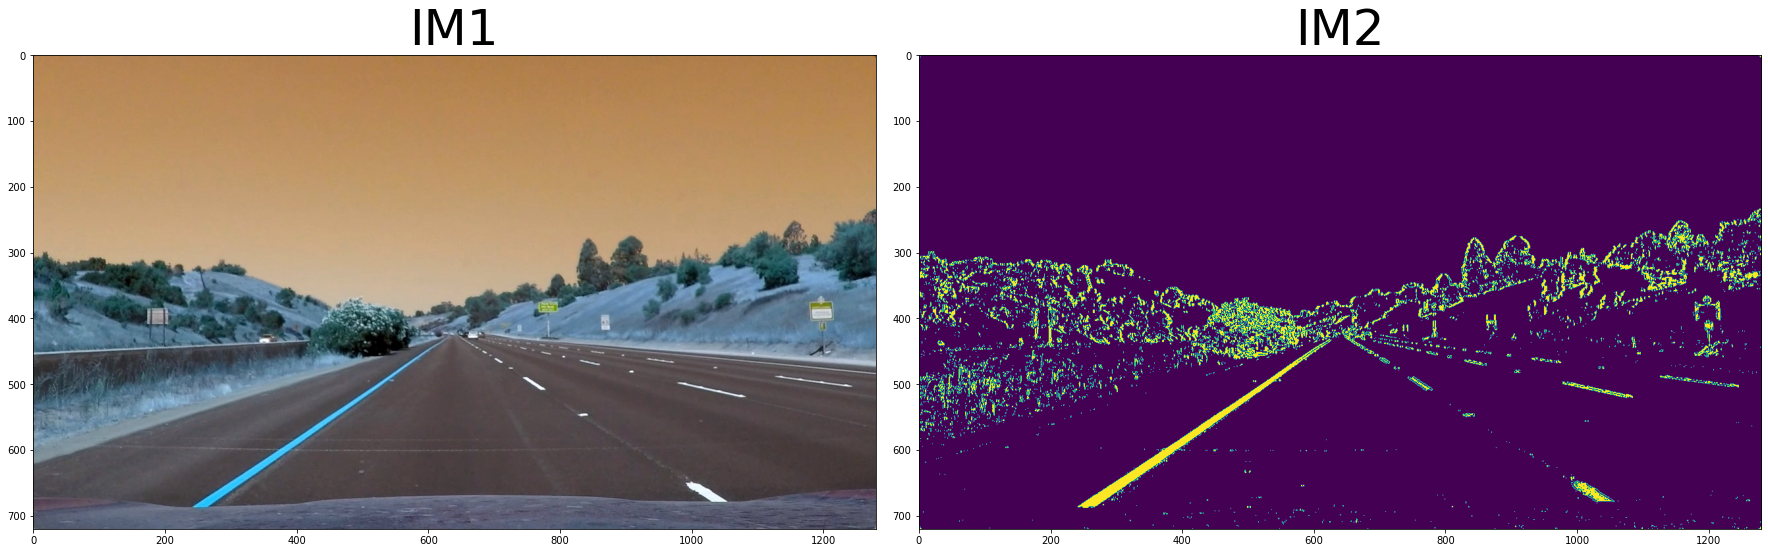

In [155]:
test_im = cv2.imread(test_ims[7])
filtered_im, filtered_im_color = combined_filter(test_im)
plot_imgs(test_im, filtered_im)


### 3. Perspective Transfomation

In [17]:
points_x = np.array([206, 588, 697, 1113])
points_y = np.array([720, 455, 455, 720])
#points_x = np.array([206, 598, 687, 1113])
#points_y = np.array([720, 455, 455, 720])
vertices = np.vstack((points_x, points_y)).transpose().astype(np.float32)
perspective_matrix = get_perspective_transform((1280, 720), vertices)
# draw lines 
#fim = filtered_im.copy()
#for i in range(4):
#    p1 = vertices[i].astype(int)
#    p2 = vertices[(i+1)%4].astype(int)
#    cv2.line(fim, tuple(p1), tuple(p2), (255, 0,0), 2)
#warped_im = cv2.warpPerspective(filtered_im, perspective_matrix, (filtered_im.shape[1], filtered_im.shape[0]), cv2.INTER_LINEAR)
#plot_imgs(fim, warped_im)

### 4. Find Line Pixels

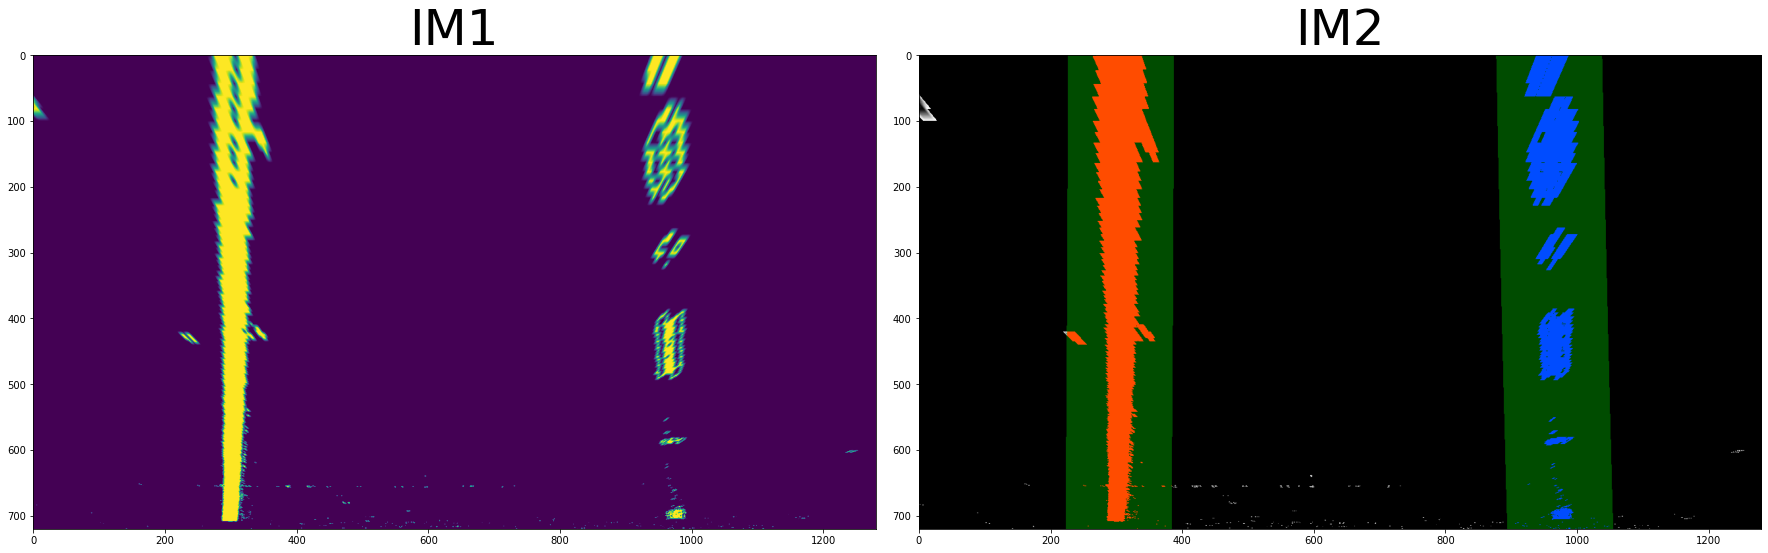

In [157]:
# inti with sliding windows
leftx, lefty, rightx, righty, out_im = find_lane_pixels(warped_im)
left_fit, right_fit = fit_polynomial((leftx, lefty), (rightx, righty))
left_pixs, right_pixs = search_around_poly(warped_im, left_fit, right_fit, margin=80)
new_left_fit, new_right_fit = fit_polynomial(left_pixs, right_pixs)
vis_im = visualize_poly(warped_im, left_pixs, right_pixs, new_left_fit, new_right_fit, margin=80)
plot_imgs(warped_im, vis_im)
#def convert_coef_pix2m(coef, xm_per_pix, ym_per_pix):

In [158]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# calculate real curvature
left_fit_world = convert_coef_pix2m(new_left_fit, xm_per_pix, ym_per_pix)
right_fit_world = convert_coef_pix2m(new_right_fit, xm_per_pix, ym_per_pix)
#y_eval_world = (warped_im.shape[0]-1) * ym_per_pix
y_eval_world = 2 * ym_per_pix
left_curverad, right_curverad = measure_curvature(left_fit_world, right_fit_world, y_eval_world )
print(left_curverad, right_curverad)

54172.347362387016 27142.18482356291


In [159]:
left_curvature

791.6368837142412

In [124]:
right_curvature

21758.030643239945

In [ ]:
# init with sliding boxes
# then search the pixels based on last fit polynomial 
# measure the curvature
# if the curvature change to much, search again with sliding window
# tracking


### 5. Fit polynomial


### 6. Calculate Curvature


### 7. Convert back to original Image
### 8. transform image coor. to world coor. 


In [185]:
def process(img):
    filtered_im, filtered_im_color = combined_filter(img)
    warped_im = cv2.warpPerspective(filtered_im, perspective_matrix, (filtered_im.shape[1], filtered_im.shape[0]), cv2.INTER_LINEAR)
    leftx, lefty, rightx, righty, out_im = find_lane_pixels(warped_im)
    left_fit, right_fit = fit_polynomial((leftx, lefty), (rightx, righty))
    left_pixs, right_pixs = search_around_poly(warped_im, left_fit, right_fit, margin=80)
    new_left_fit, new_right_fit = fit_polynomial(left_pixs, right_pixs)
    vis_im = visualize_poly(warped_im, left_pixs, right_pixs, new_left_fit, new_right_fit, margin=80)
    left_fit_world = convert_coef_pix2m(new_left_fit, xm_per_pix, ym_per_pix)
    right_fit_world = convert_coef_pix2m(new_right_fit, xm_per_pix, ym_per_pix)
    y_eval_world = (warped_im.shape[0]-1) * ym_per_pix
    y_eval_world = 2 * ym_per_pix
    left_curverad, right_curverad = measure_curvature(left_fit_world, right_fit_world, y_eval_world )
    #print(left_curverad, right_curverad)
    return vis_im
    #return warped_im

In [74]:
from collections import namedtuple
from collections import deque

class Line:
    def __init__(self, x, y, line_coef=None, xm_per_pix= 3.7/700, ym_per_pix= 30/720, poly_order=2):
        self.x = x
        self.y = y
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix
        self.poly_order = poly_order
        self._coef = line_coef
        self._coef_world = None
        self._curverad_world = None
        self._x_base = None
        self.y_max = self.y.max()
    @property 
    def xy(self):
        return (self.x, self.y)
        
    @property
    def x_base(self):
        if self._x_base is None:
            self._x_base = self._get_x(self.y_max)
        return self._x_base
    @property
    def coef(self):
        if self._coef is None:
            self._coef = np.polyfit(self.y, self.x,  self.poly_order)
        return self._coef
    
    @property
    def coef_world(self):
        if self._coef_world is None:
            self._coef_world = self._convert_coef_pix2m(self.coef, self.xm_per_pix, self.ym_per_pix)
        return self._coef_world
    @property
    def curverad(self):
        if self._curverad_world is None:
            y_eval = self.y_max * self.ym_per_pix
            self._curverad_world = ((1 + (2*self.coef_world[0] * y_eval + self.coef_world[1])**2)**(3/2))/abs(2*self.coef_world[0])
        return self._curverad_world
    
    def _get_x(self, y):
        return self.coef[0] * y**2 + self.coef[1] * y + self.coef[2]
    
    def _convert_coef_pix2m(self, coef, xm_per_pix, ym_per_pix):
        a = coef[0] * xm_per_pix / (ym_per_pix**2)
        b = coef[0] * xm_per_pix / ym_per_pix
        return np.array([a, b, coef[2]])
        
        
line_pair = namedtuple('Line_pair', ['left', 'right'])

class Lane_finder:
    
    def __init__(self, perspective_mtx=None, camera_mtx=None, dist=None, buffer_size=3):
        self.camera_mtx = camera_mtx
        self.dist = dist
        self.line_buffer = deque(maxlen=buffer_size)
        self.init = False
        self.curverad_diff_thresh = 500
        self.x_base_diff_thresh = 500
        self.min_curverad = 500
        points_x = np.array([206, 588, 697, 1113])
        points_y = np.array([720, 455, 455, 720])
        self.src_vertices = np.vstack((points_x, points_y)).transpose().astype(np.float32)
        self.perspective_mtx = perspective_mtx
        self._inv_perspective_mtx = None
        
    
    @property
    def inv_perspective_mtx(self):
        if self._inv_perspective_mtx is None:
            self._inv_perspective_mtx = np.linalg.inv(self.perspective_mtx)
        return self._inv_perspective_mtx
        
    @property
    def last_line_pair(self):
        if len(self.line_buffer) == 0:
            return None
        return self.line_buffer[-1]
    
    def get_perspective_transform(self, size, src_vertices, offset=(300, 0)):
        offset_x, offset_y = offset
        w, h = size
        dst_vertices = np.array([[offset_x, h], [offset_x, offset_y], [w-offset_x, offset_y], [w-offset_x, h]], dtype=np.float32)
        return cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    
    def check_valid(self, line_pair):
        if len(self.line_buffer) == 0:
            return True
        # check mininal of radius of curve
        if line_pair.left.curverad < self.min_curverad or line_pair.right.curverad < self.min_curverad:
            #print('curverad too small')
            return False
        # check diff of radius of curve
        left_curverad_invalid =  abs(line_pair.left.curverad - self.last_line_pair.left.curverad) > self.curverad_diff_thresh
        right_curverad_invalid =  abs(line_pair.right.curverad - self.last_line_pair.right.curverad) > self.curverad_diff_thresh
        #print('current_left curverad: {}, last left curverad: {}'.format(line_pair.left.curverad, self.last_line_pair.left.curverad))
        #print('current right curverad: {}, last right curverad: {}'.format(line_pair.right.curverad, self.last_line_pair.right.curverad))
        if left_curverad_invalid or right_curverad_invalid:
            #print('curverad diff too big')
            return False
        
        #print('left x_base')
        #print(abs(self.last_line_pair.left.x_base - line_pair.left.x_base))
        #print('right x_base')
        #print(abs(self.last_line_pair.right.x_base - line_pair.right.x_base))
        # check x base
        if abs(self.last_line_pair.left.x_base - line_pair.left.x_base) > self.x_base_diff_thresh \
            or abs(self.last_line_pair.right.x_base - line_pair.right.x_base) > self.x_base_diff_thresh:
            #print('x_base diff too big')
            return False
        return True
    
    def get_avg_line_pair(self, n=0):
        n_l = len(self.line_buffer)
        if n == 0 or n > n_l: 
            n = n_l
        left_coefs = []
        right_coefs = []
        for i in range(n_l-1, n_l-1-n, -1):
            left_coefs.append(self.line_buffer[i].left.coef)
            right_coefs.append(self.line_buffer[i].right.coef)
        mean_left_coef = np.array(left_coefs).mean(axis=0)
        mean_right_coef = np.array(right_coefs).mean(axis=0)
        # use last pixs for average line for efficiency
        left_line = Line(x=self.last_line_pair.left.x, y=self.last_line_pair.left.y, line_coef=mean_left_coef)
        right_line = Line(x=self.last_line_pair.right.x, y=self.last_line_pair.right.y, line_coef=mean_right_coef)
        return (left_line, right_line) 
            
            
    def process(self, img, vis='top'):
        undistorted_img = cv2.undistort(img, self.camera_mtx, self.dist, None, self.camera_mtx)
        filtered_im = self.filter_im(undistorted_img)
        if self.perspective_mtx is None:
            self.perspective_mtx = get_perspective_transform(
                (undistorted_img.shape[1], undistorted_img.shape[0]),
                 self.src_vertices)
        warped_im = cv2.warpPerspective(filtered_im, 
                                        self.perspective_mtx, 
                                        (filtered_im.shape[1], filtered_im.shape[0]), 
                                        cv2.INTER_LINEAR)
        if not self.init:
            left_pixs, right_pixs, xbase = self.find_pixels_window(warped_im)
            left_line = Line(left_pixs[0], left_pixs[1])
            right_line = Line(right_pixs[0], right_pixs[1])
            self.line_buffer.append(line_pair(left_line, right_line))
            self.init = True
        else:
            left_pixs, right_pixs = self.search_around_poly(warped_im, 
                                                       self.last_line_pair.left.coef, 
                                                       self.last_line_pair.right.coef, 
                                                       margin=100)
            left_line = Line(left_pixs[0], left_pixs[1])
            right_line = Line(right_pixs[0], right_pixs[1])
            if self.check_valid(line_pair(left_line, right_line)):
                self.line_buffer.append(line_pair(left_line, right_line))
            else: 
                self.init = False
        if vis == 'top':
            avg_line_left, avg_line_right = self.get_avg_line_pair()
            #return self.vis_poly(warped_im, avg_line_left, avg_line_right)
            return self.vis_poly(warped_im, self.last_line_pair.left, self.last_line_pair.right)
        elif vis == 'camera':
            avg_line_left, avg_line_right = self.get_avg_line_pair()
            return self.vis_camera(undistorted_img, warped_im, avg_line_left, avg_line_right)
        else:
            return warped_im
        
    def filter_im(self, img, s_thresh=(130, 255), sx_thresh=(50, 130)):
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        binary = np.zeros_like(scaled_sobel)
        sx_idx = (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])
        binary[sx_idx] = 1

        # Threshold color channel
        s_idx = (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])
        binary[s_idx] = 1
        return binary
    
    def vis_poly(self, binary_warped, left_line, right_line, margin=100):
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        leftx, lefty = left_line.xy
        rightx, righty = right_line.xy
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        left_fit = left_line.coef
        right_fit = right_line.coef
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        return result
    
    def vis_camera(self, original_img, warped_img, left_line, right_line):
       # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        left_fit = left_line.coef
        right_fit = right_line.coef
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.inv_perspective_mtx, (original_img.shape[1], original_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
        return result
        
    def find_pixels_window(self, binary_warped, x_base=None, nwindows=9, xmargin=100, minpix=20):
        if x_base is None:
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            midpoint = int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        else:
            leftx_base, rightx_base = x_base
        window_height = int(binary_warped.shape[0]//nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - xmargin
            win_xleft_high = leftx_current + xmargin  # Update this
            win_xright_low = rightx_current - xmargin  # Update this
            win_xright_high = rightx_current + xmargin  # Update this

            y_idx = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
            good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & y_idx).nonzero()[0]
            good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & y_idx).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = nonzerox[good_left_inds].mean().astype(int)
            if len(good_right_inds) > minpix:
                rightx_current = nonzerox[good_right_inds].mean().astype(int)

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return (leftx, lefty), (rightx, righty), (leftx_base, rightx_base)
    
    def search_around_poly(self, binary_warped, left_fit, right_fit, margin=100):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        nonzero_x_curve_left = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
        nonzero_x_curve_right = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
        left_lane_inds = (nonzerox >= nonzero_x_curve_left - margin) & (nonzerox < nonzero_x_curve_left + margin)
        right_lane_inds = (nonzerox >= nonzero_x_curve_right - margin) & (nonzerox < nonzero_x_curve_right + margin)

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return (leftx, lefty), (rightx, righty)

In [75]:
finder = Lane_finder(camera_mtx=mtx, dist=dist, buffer_size=3)

In [69]:
%matplotlib qt

project_ims = glob.glob('project_images/out*.png')

p = 'project_images/out{}.png'
for i in range(580, 628):
    test_im = cv2.imread(p.format(i))[:,:,::-1]
    result = finder.process(test_im, 'camera')
    cv2.imshow('img', result)
    cv2.waitKey(100)

cv2.destroyAllWindows()
    

left x_base
0.38160767302093745
right x_base
5.152570548975291


In [66]:

finder1 = Lane_finder(perspective_mtx=perspective_matrix, camera_mtx=mtx, dist=dist, buffer_size=5)
test_im = cv2.imread(p.format(585))[:,:,::-1]
result = finder1.process(test_im, 'top')
plot_imgs(test_im[:,:,::-1], result)

#### points for perspective transform

In [77]:
# test video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [78]:
output_video = 'project_video_out.mp4'

#output_video = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(lambda im: finder.process(im, vis='camera')) #NOTE: this function expects color images!!

In [79]:
#white_clip.ipython_display(width=900, audio=False)
white_clip.write_videofile(output_video, audio=False)

t:   0%|          | 3/1260 [00:00<01:04, 19.51it/s, now=None]

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4


In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))